# P5 - Notebook Maintenance

Idée : évaluer la performance du meilleur algorithme de clustering sélectionné, au cours de différentes périodes, à laquelle des clients sont ajoutés.
Dans un premier temps on constitue un DF correspondant aux clients ayant passé une commande dans les 6 premiers mois des dates comprises dans le dataset.
On ajoutera ensuite des périodes d'un mois et nous vérifierons la stabilité du clustering.
On utilise pour cela l'Adjusted Rand Index Score (ARI). Cette métrique évalue la proportion de paires de points qui sont groupées de la même façon lors de la comparaison entre 2 itérations d'un modèle de clustering : soit parce que, dans les deux cas, ces 2 points appartiennent au même cluster, soit parce que, dans les deux cas, ils appartiennent à des clusters différents.
Un ARI de 1 signifie que toutes les paires de poitns sont groupées de la même façon lors des différentes itérations. Un ARI de 0 équivaut à un regroupement aléatoire.
Un seuil d'ARI de 0.9 semble être un bon compromis.

In [1]:
# Import des packages :
!pip install --upgrade scikit-learn
!pip install yellowbrick
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram
from datetime import datetime
from sklearn.compose import make_column_transformer
import warnings

In [2]:
# Ignorer tous les avertissements
warnings.filterwarnings("ignore")

**Import des jeux de données**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import du jeu de données complet
data = pd.read_csv("/content/drive/My Drive/Formation/Notebooks/jeu_donnees_clustering_maintenance.csv",
                    index_col="customer_unique_id", parse_dates=["last_purchase_date", "first_purchase_date"])

# Import du jeu de données - échantillon ayant servi aux modèles de clustering :
df1 = pd.read_csv("/content/drive/My Drive/Formation/Notebooks/jeu_donnees_clustering.csv",
                    index_col="customer_unique_id", parse_dates=["last_purchase_date", "first_purchase_date"])

### Maintenance

#### Tentative avec le jeu de données échantillon :

In [5]:
df1.head()

,nb_orders,last_purchase_date,first_purchase_date,mean_delivery_delay,max_delivery_delay,mean_review_score,max_review_score,min_review_score,largest_payment_type,mean_payment_installments,...,total_price,mean_order_price,largest_product_category_name,recency,delivery_delay,several_orders,payment_installment,order_last_month,order_last_quarter,order_last_year
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,2,2018-07-28 00:23:49,2018-08-13 09:14:07,14.188414,14.188414,4.0,4.0,4.0,voucher,1.5,...,122.07,122.070,house_products,32,0,1,1,0,1,1
004288347e5e88a27ded2bb23747066c,2,2017-07-27 14:13:03,2018-01-14 07:36:54,16.694051,20.073449,5.0,5.0,5.0,credit_card,2.0,...,354.37,177.185,fashion,398,0,1,1,0,0,0
004b45ec5c64187465168251cd1c9c2f,2,2017-09-01 12:11:23,2018-05-26 19:42:48,21.287928,21.287928,3.0,5.0,1.0,boleto,1.0,...,147.72,73.860,tools,362,0,1,0,0,0,1
0058f300f57d7b93c477a131a59b36c3,2,2018-02-19 17:11:34,2018-03-22 18:09:41,11.037535,11.037535,3.0,5.0,1.0,voucher,1.0,...,175.58,87.790,house_products,190,0,1,0,0,0,1
00a39521eb40f7012db50455bf083460,2,2018-05-23 20:14:21,2018-06-03 10:12:57,18.233918,21.330023,4.0,4.0,4.0,credit_card,1.0,...,123.25,61.625,leasures,97,0,1,0,0,0,1


In [6]:
df1.shape

(20667, 23)

##### On crée un dataframe "de base" contenant les données pour les 6 premiers mois, on en crée ensuite 9 autres en ajoutant un mois à chaque fois.

In [7]:
date_min = df1.first_purchase_date.min()

In [8]:
df_t0 = df1[df1['first_purchase_date'] <= (date_min + pd.DateOffset(months=6))]

In [9]:
df_t0.shape

(1050, 23)

In [10]:
# Listes qui contiendra les différents DF :
liste_dataframes = []

# Date fin dataframe précédent:
date_max = df_t0['first_purchase_date'].max()

# Nombre de dataframes à créer :
nb_dataframes = 9

# Boucle pour créer les dataframes
for i in range(nb_dataframes):
    # On calcule la date de fin pour chaque dataframe :
    date_fin = date_max + pd.DateOffset(months = 1)

    # On sélectionne les données entre date_debut et date_fin
    df_temp = df1[df1['first_purchase_date'] <= date_fin]

    # On ajoute le dataframe à la liste
    liste_dataframes.append(df_temp)

    # On met à jour la date max pour la prochaine itération
    date_max = date_fin

In [11]:
# On définit nos DataFrames :
df_t1 = liste_dataframes[0]
df_t2 = liste_dataframes[1]
df_t3 = liste_dataframes[2]
df_t4 = liste_dataframes[3]
df_t5 = liste_dataframes[4]
df_t6 = liste_dataframes[5]
df_t7 = liste_dataframes[6]
df_t8 = liste_dataframes[7]
df_t9 = liste_dataframes[8]

# On ajoute df_t0 en première place de la liste :
liste_dataframes = [df_t0, df_t1, df_t2, df_t3, df_t4, df_t5, df_t6, df_t7, df_t8, df_t9]

##### Evolution du nombre de clients

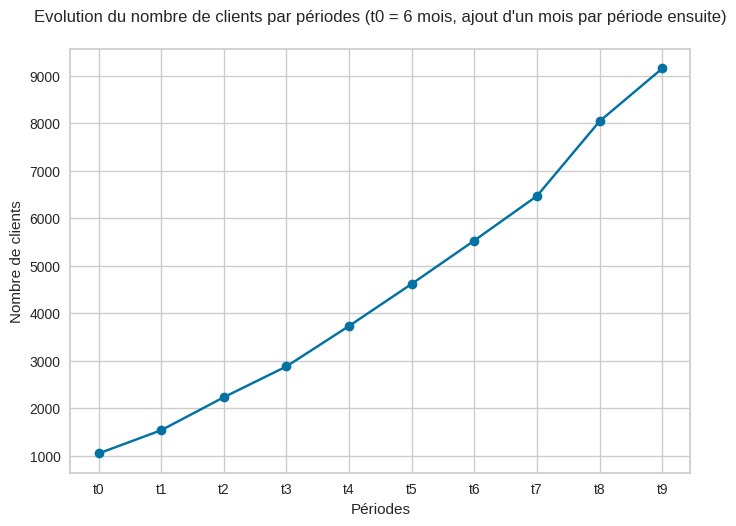

In [12]:
# On crée une liste pour stocker les tailles des dataframes
tailles_dataframes = [df.shape[0] for df in liste_dataframes]
periodes = [f"t{i}" for i in range(len(liste_dataframes))]
# On trace les tailles des dataframes par rapport à leur nom
plt.plot(periodes, tailles_dataframes, marker='o')
plt.xlabel('Périodes')
plt.ylabel('Nombre de clients')
plt.title("Evolution du nombre de clients par périodes (t0 = 6 mois, ajout d'un mois par période ensuite)", pad = 20)
plt.show()

##### Preprocessing

In [13]:
# Séparation des variables et application de différents 'transformers':
skw_vars = ['nb_orders', 'total_price', 'mean_review_score']
vars_to_scale = ['recency']
var_pass = ["delivery_delay"]
all_fts = [*skw_vars, *vars_to_scale, *var_pass]

log_transformer = FunctionTransformer(func=np.log1p)
pre_processor = make_column_transformer(
        (make_pipeline(log_transformer, StandardScaler()), skw_vars),
        (StandardScaler(), vars_to_scale),
        ('passthrough', var_pass)
)

In [14]:
def preprocessing(df):
  X_scaled = pre_processor.fit_transform(df)
  X_scaled_df = pd.DataFrame(data = X_scaled, columns = all_fts, index = df.index)
  return X_scaled_df

In [15]:
# On crée des dataframes avec les données scalées de chaque période :

X_scaled_df_t0 = preprocessing(df_t0)
X_scaled_df_t1 = preprocessing(df_t1)
X_scaled_df_t2 = preprocessing(df_t2)
X_scaled_df_t3 = preprocessing(df_t3)
X_scaled_df_t4 = preprocessing(df_t4)
X_scaled_df_t5 = preprocessing(df_t5)
X_scaled_df_t6 = preprocessing(df_t6)
X_scaled_df_t7 = preprocessing(df_t7)
X_scaled_df_t8 = preprocessing(df_t8)
X_scaled_df_t9 = preprocessing(df_t9)

liste_scaled_df = [X_scaled_df_t0, X_scaled_df_t1, X_scaled_df_t2, X_scaled_df_t3, X_scaled_df_t4, X_scaled_df_t5, X_scaled_df_t6, X_scaled_df_t7, X_scaled_df_t8, X_scaled_df_t9]

##### Entrainement du modèle en t0

In [16]:
kmeans_t0 = KMeans(n_clusters=5, n_init = 10, random_state = 22)
kmeans_t0.fit(X_scaled_df_t0)

KMeans(n_clusters=5, n_init=10, random_state=22)

Définition d'une fonction qui renvoi les labels du modèle entraîné à la date t :

In [17]:
def label_t(df):
  model = KMeans(n_clusters=5, n_init = 10, random_state = 22)
  model.fit(df)
  label = model.labels_
  return label

##### Calcul et visualisation de l'ARI au cours du temps

Idée :

-> créer une liste d'ARI.

-> Faire une boucle qui calcule les ARI en comparant les labels renvoyés par le modèle entrainé en t0 à ceux du modèle entrainé en t.

-> Tant que l'ARI est > à un certain seuil, on ajoute l'ARI calculé de la sorte à la liste

-> Si l'ari est < à ce seuil, alors on "met à jour le modèle" et on prend la version entrainée en t et on compare de nouveaux les labels.

A la période 1, le modèle est toujours pertinent
A la période 2, le modèle n'est plus pertinent, on le met à jour
A la période 3, le modèle est toujours pertinent
A la période 4, le modèle est toujours pertinent
A la période 5, le modèle est toujours pertinent
A la période 6, le modèle est toujours pertinent
A la période 7, le modèle est toujours pertinent
A la période 8, le modèle est toujours pertinent
A la période 9, le modèle n'est plus pertinent, on le met à jour


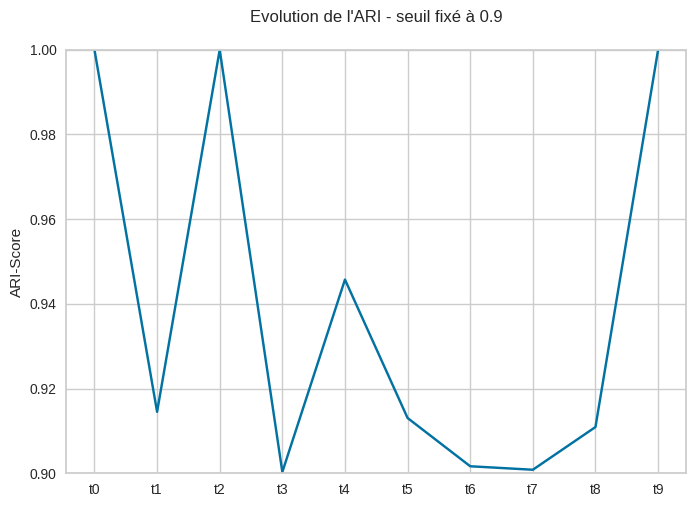

In [18]:
ARI_list = [adjusted_rand_score(kmeans_t0.labels_, kmeans_t0.labels_)]
ARI_threshold = 0.9
model = kmeans_t0
for i, df, X_scaled_df in zip(range(len(liste_dataframes[1:])), liste_dataframes[1:], liste_scaled_df[1:]):
  label = model.predict(X_scaled_df)
  ari=adjusted_rand_score(label, label_t(X_scaled_df))
  if ari >= ARI_threshold:
    print(f"A la période {i + 1}, le modèle est toujours pertinent")
    ARI_list.append(ari)
  else:
    print(f"A la période {i + 1}, le modèle n'est plus pertinent, on le met à jour")
    model = KMeans(n_clusters=5, n_init = 10, random_state = 22).fit(X_scaled_df)
    label = model.predict(X_scaled_df)
    ari=adjusted_rand_score(label, label)
    ARI_list.append(ari)

# Visualisation :
plt.figure()
plt.plot(range(len(ARI_list)), ARI_list)
plt.xticks(range(len(ARI_list)), [f"t{i}" for i in range(len(ARI_list))])
plt.ylabel("ARI-Score")
plt.ylim([0.9, 1])
plt.title(f"Evolution de l'ARI - seuil fixé à {ARI_threshold}", pad = 20)
plt.show()

##### Visualisation des trajectoires des centroïdes pour les clients composant le dataframe de la 1e période:

In [19]:
df_t0.loc[:, "k0_labels"] = kmeans_t0.fit_predict(X_scaled_df_t0)
idx_label_00 = df_t0.loc[:, "k0_labels"].index

In [20]:
pca = PCA()
pca = pca.fit(X_scaled_df_t0.loc[idx_label_00, :])
X_proj = pca.transform(X_scaled_df_t0.loc[idx_label_00, :])

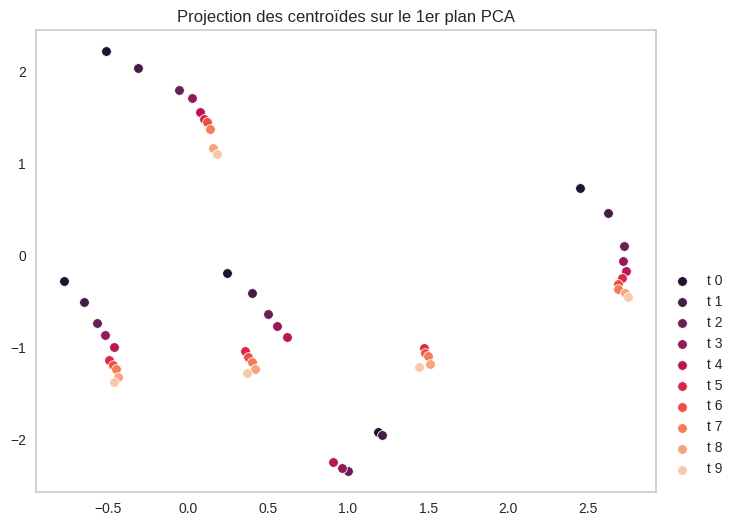

In [21]:
# On récupère les centroïdes pour chaque période, puis les transforme via la PCA :
centroids_maintenance = []
for scaled_df in liste_scaled_df:
  model = KMeans(n_clusters=5, n_init = 10, random_state = 22).fit(scaled_df.loc[idx_label_00, :])
  centroids = model.cluster_centers_
  pca_centroids = pca.transform(centroids)
  #pca_centroids_2d = pca_centroids[:, :2]
  centroids_maintenance.append(pca_centroids)

# Visualisation :
plt.figure(figsize=(8, 6))
palette = sns.color_palette("rocket", len(centroids_maintenance))

for i, centroids in enumerate(centroids_maintenance):
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], marker='o', color=palette[i], label=f't {i}')

plt.title('Projection des centroïdes sur le 1er plan PCA')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.grid(False)
plt.show()

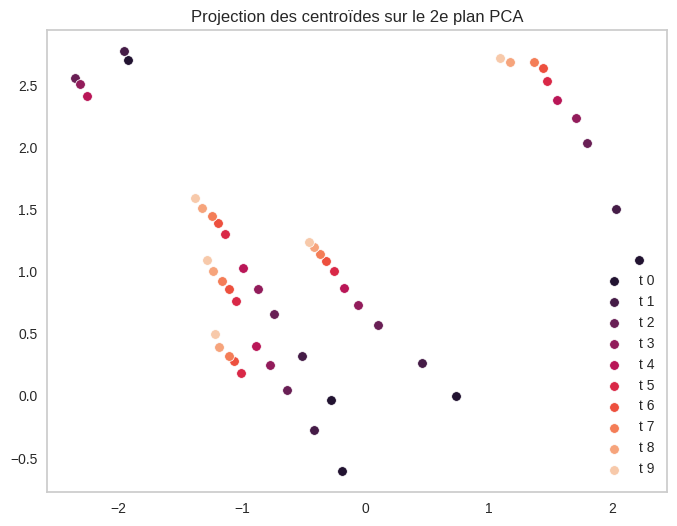

In [22]:
# On récupère les centroïdes pour chaque période, puis les transforme via la PCA :
centroids_maintenance = []
for scaled_df in liste_scaled_df:
  model = KMeans(n_clusters=5, n_init = 10, random_state = 22).fit(scaled_df.loc[idx_label_00, :])
  centroids = model.cluster_centers_
  pca_centroids = pca.transform(centroids)
  #pca_centroids_2d = pca_centroids[:, :2]
  centroids_maintenance.append(pca_centroids)

# Visualisation :
plt.figure(figsize=(8, 6))
palette = sns.color_palette("rocket", len(centroids_maintenance))

for i, centroids in enumerate(centroids_maintenance):
    sns.scatterplot(x=centroids[:, 1], y=centroids[:, 2], marker='o', color=palette[i], label=f't {i}')

plt.title('Projection des centroïdes sur le 2e plan PCA')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.grid(False)
plt.show()

#### Tentative avec dataset complet, 1er dataframe de 6 mois et évolution tous les mois :

In [23]:
# Import du jeu de données
data = pd.read_csv("/content/drive/My Drive/Formation/Notebooks/jeu_donnees_clustering_maintenance.csv",
                    index_col="customer_unique_id", parse_dates=["last_purchase_date", "first_purchase_date"])

In [24]:
date_min = data.first_purchase_date.min()

In [25]:
df_t0 = data[data['first_purchase_date'] <= (date_min + pd.DateOffset(months=6))]

In [26]:
df_t0.shape

(4946, 23)

In [27]:
# Listes qui contiendra les différents DF :
liste_dataframes = []

# Date fin dataframe précédent:
date_max = df_t0['first_purchase_date'].max()

# Nombre de dataframes à créer
nb_dataframes = 9

# Boucle pour créer les dataframes
for i in range(nb_dataframes):
    # On calcule la date de fin pour chaque dataframe :
    date_fin = date_max + pd.DateOffset(months=1)

    # On sélectionne les données entre date_debut et date_fin
    df_temp = data[data['first_purchase_date'] <= date_fin]

    # On ajoute le dataframe à la liste
    liste_dataframes.append(df_temp)

    # On met à jour la date max pour la prochaine itération
    date_max = date_fin

In [28]:
# On définit nos DataFrames :
df_t1 = liste_dataframes[0]
df_t2 = liste_dataframes[1]
df_t3 = liste_dataframes[2]
df_t4 = liste_dataframes[3]
df_t5 = liste_dataframes[4]
df_t6 = liste_dataframes[5]
df_t7 = liste_dataframes[6]
df_t8 = liste_dataframes[7]
df_t9 = liste_dataframes[8]

# On ajoute df_t0 en première place de la liste :
liste_dataframes = [df_t0, df_t1, df_t2, df_t3, df_t4, df_t5, df_t6, df_t7, df_t8, df_t9]

##### Evolution du nombre de clients

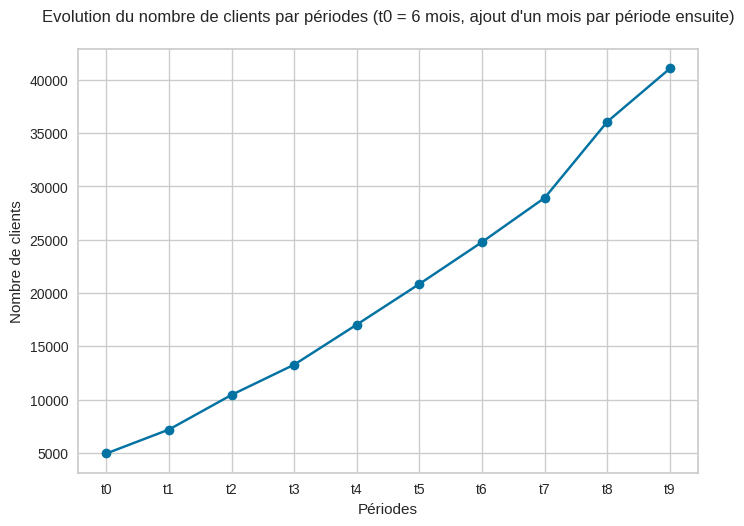

In [29]:
# On crée une liste pour stocker les tailles des dataframes
tailles_dataframes = [df.shape[0] for df in liste_dataframes]
periodes = [f"t{i}" for i in range(len(liste_dataframes))]
# On trace les tailles des dataframes par rapport à leur nom
plt.plot(periodes, tailles_dataframes, marker='o')
plt.xlabel('Périodes')
plt.ylabel('Nombre de clients')
plt.title("Evolution du nombre de clients par périodes (t0 = 6 mois, ajout d'un mois par période ensuite)", pad = 20)
plt.show()

##### Preprocessing

In [30]:
X_scaled_df_t0 = preprocessing(df_t0)
X_scaled_df_t1 = preprocessing(df_t1)
X_scaled_df_t2 = preprocessing(df_t2)
X_scaled_df_t3 = preprocessing(df_t3)
X_scaled_df_t4 = preprocessing(df_t4)
X_scaled_df_t5 = preprocessing(df_t5)
X_scaled_df_t6 = preprocessing(df_t6)
X_scaled_df_t7 = preprocessing(df_t7)
X_scaled_df_t8 = preprocessing(df_t8)
X_scaled_df_t9 = preprocessing(df_t9)

liste_scaled_df = [X_scaled_df_t0, X_scaled_df_t1, X_scaled_df_t2, X_scaled_df_t3, X_scaled_df_t4, X_scaled_df_t5, X_scaled_df_t6, X_scaled_df_t7, X_scaled_df_t8, X_scaled_df_t9]

##### Entrainement du modèle en t0

In [31]:
kmeans_t0 = KMeans(n_clusters=5, n_init = 10, random_state = 22)
kmeans_t0.fit(X_scaled_df_t0)

KMeans(n_clusters=5, n_init=10, random_state=22)

##### Calcul et visualisation de l'ARI au cours du temps

A la période 1, le modèle est toujours pertinent
A la période 2, le modèle n'est plus pertinent, on le met à jour
A la période 3, le modèle est toujours pertinent
A la période 4, le modèle est toujours pertinent
A la période 5, le modèle est toujours pertinent
A la période 6, le modèle est toujours pertinent
A la période 7, le modèle est toujours pertinent
A la période 8, le modèle est toujours pertinent
A la période 9, le modèle est toujours pertinent


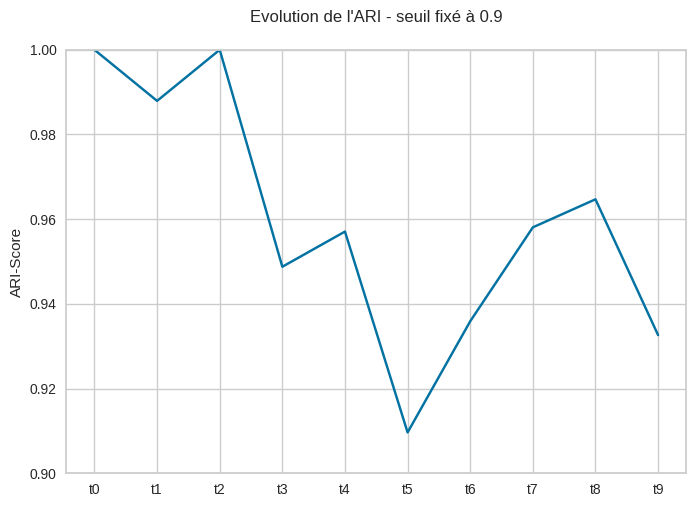

In [32]:
ARI_list = [adjusted_rand_score(kmeans_t0.labels_, kmeans_t0.labels_)]
ARI_threshold = 0.9
model = kmeans_t0
for i, df, X_scaled_df in zip(range(len(liste_dataframes[1:])), liste_dataframes[1:], liste_scaled_df[1:]):
  label = model.predict(X_scaled_df)
  ari=adjusted_rand_score(label, label_t(X_scaled_df))
  if ari >= ARI_threshold:
    print(f"A la période {i + 1}, le modèle est toujours pertinent")
    ARI_list.append(ari)
  else:
    print(f"A la période {i + 1}, le modèle n'est plus pertinent, on le met à jour")
    model = KMeans(n_clusters=5, n_init = 10, random_state = 22).fit(X_scaled_df)
    label = model.predict(X_scaled_df)
    ari=adjusted_rand_score(label, label)
    ARI_list.append(ari)

# Visualisation :
plt.figure()
plt.plot(range(len(ARI_list)), ARI_list)
plt.xticks(range(len(ARI_list)), [f"t{i}" for i in range(len(ARI_list))])
plt.ylabel("ARI-Score")
plt.ylim([0.9, 1])
plt.title(f"Evolution de l'ARI - seuil fixé à {ARI_threshold}", pad = 20)
plt.show()

##### Visualisation des trajectoires des centroïdes pour les clients composant le dataframe de la 1e période:

In [33]:
df_t0.loc[:, "k0_labels"] = kmeans_t0.fit_predict(X_scaled_df_t0)
idx_label_00 = df_t0.loc[:, "k0_labels"].index

In [34]:
pca = PCA()
pca = pca.fit(X_scaled_df_t0.loc[idx_label_00, :])
X_proj = pca.transform(X_scaled_df_t0.loc[idx_label_00, :])

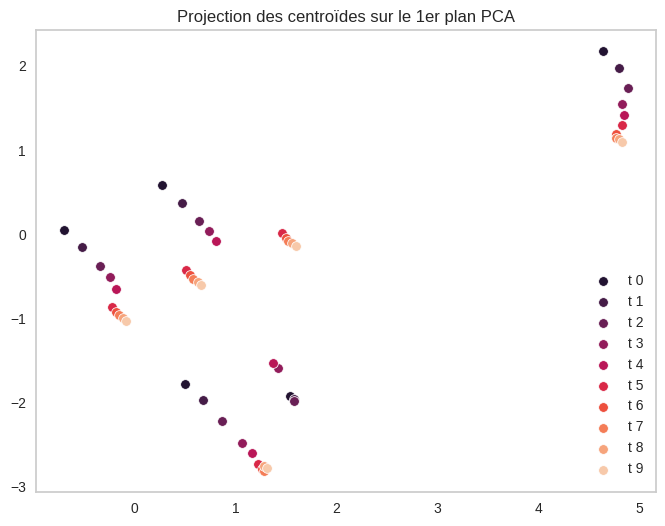

In [35]:
# On récupère les centroïdes pour chaque période, puis les transforme via la PCA :
centroids_maintenance = []
for scaled_df in liste_scaled_df:
  model = KMeans(n_clusters=5, n_init = 10, random_state = 22).fit(scaled_df.loc[idx_label_00, :])
  centroids = model.cluster_centers_
  pca_centroids = pca.transform(centroids)
  #pca_centroids_2d = pca_centroids[:, :2]
  centroids_maintenance.append(pca_centroids)

# Visualisation :
plt.figure(figsize=(8, 6))
palette = sns.color_palette("rocket", len(centroids_maintenance))

for i, centroids in enumerate(centroids_maintenance):
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], marker='o', color=palette[i], label=f't {i}')

plt.title('Projection des centroïdes sur le 1er plan PCA')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.grid(False)
plt.show()

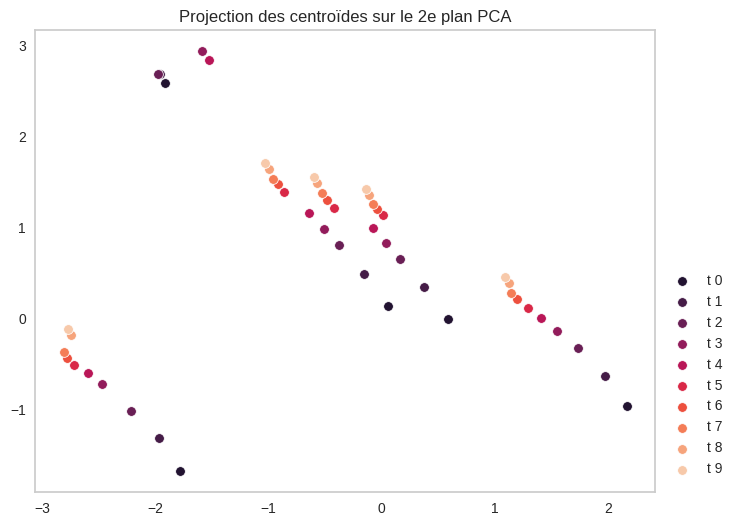

In [36]:
# On récupère les centroïdes pour chaque période, puis les transforme via la PCA :
centroids_maintenance = []
for scaled_df in liste_scaled_df:
  model = KMeans(n_clusters=5, n_init = 10, random_state = 22).fit(scaled_df.loc[idx_label_00, :])
  centroids = model.cluster_centers_
  pca_centroids = pca.transform(centroids)
  #pca_centroids_2d = pca_centroids[:, :2]
  centroids_maintenance.append(pca_centroids)

# Visualisation :
plt.figure(figsize=(8, 6))
palette = sns.color_palette("rocket", len(centroids_maintenance))

for i, centroids in enumerate(centroids_maintenance):
    sns.scatterplot(x=centroids[:, 1], y=centroids[:, 2], marker='o', color=palette[i], label=f't {i}')

plt.title('Projection des centroïdes sur le 2e plan PCA')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.grid(False)
plt.show()